In [2]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import cv2
import shutil
import keras
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
!pip install imutils
from imutils import paths
from sklearn.utils import shuffle

In [4]:
width,height=224,224

imagePaths = list(paths.list_images('C:\\Users\\santhosh\\OneDrive\\Desktop\\diabetic retinopathy\\train\\'))

data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]   
    image = load_img(imagePath, target_size=(width, height))
    image = img_to_array(image)
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

data, labels = shuffle(data, labels)

print(data.shape)
print(labels.shape)

(3662, 224, 224, 3)
(3662, 5)


In [5]:
data = data / 255.0

In [6]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=.2)

print("Train images:",x_train.shape)
print("Test images:",x_test.shape)
print("Train label:",y_train.shape)
print("Test label:",y_test.shape)

Train images: (2929, 224, 224, 3)
Test images: (733, 224, 224, 3)
Train label: (2929, 5)
Test label: (733, 5)


In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2)

print("Train images:",x_train.shape)
print("Test images:",x_val.shape)
print("Train label:",y_train.shape)
print("Test label:",y_val.shape)

Train images: (2343, 224, 224, 3)
Test images: (586, 224, 224, 3)
Train label: (2343, 5)
Test label: (586, 5)


In [8]:
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras import layers

In [9]:
Vgg16 = VGG16(include_top=False, input_shape= (224,224,3)) 

Vgg16.trainable=False

In [10]:
model = Sequential()
model.add(Vgg16)
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64 , activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(32 , activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(5 , activation="sigmoid"))

model.compile( optimizer="adam" , loss="binary_crossentropy" , metrics=["binary_accuracy"] )

In [11]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy' , patience=10 , restore_best_weights=True)]

history = model.fit(x_train , y_train , epochs=5 , batch_size=64,
                    validation_data=(x_val,y_val), verbose=1 , callbacks = callbacks)

Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 166s 4s/step - binary_accuracy: 0.7488 - loss: 0.5918 - val_binary_accuracy: 0.8956 - val_loss: 0.2962
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - binary_accuracy: 0.8610 - loss: 0.3253 - val_binary_accuracy: 0.9000 - val_loss: 0.2809
Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 162s 4s/step - binary_accuracy: 0.8661 - loss: 0.3225 - val_binary_accuracy: 0.8993 - val_loss: 0.2618
Epoch 4/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - binary_accuracy: 0.8788 - loss: 0.2928 - val_binary_accuracy: 0.9007 - val_loss: 0.2538
Epoch 5/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - binary_accuracy: 0.8908 - loss: 0.2793 - val_binary_accuracy: 0.8973 - val_loss: 0.2544


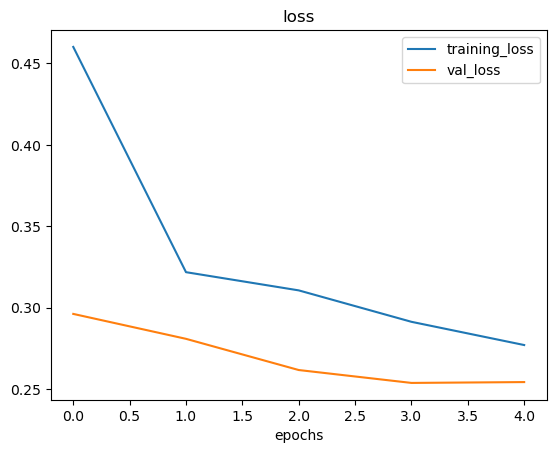

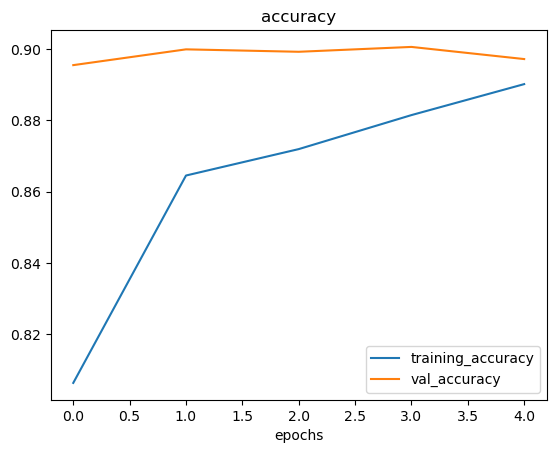

In [12]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["binary_accuracy"]
  val_accuracy = history.history["val_binary_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()
  
plot_curves(history)

In [42]:
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    directory=r'C:\Users\santhosh\OneDrive\Desktop\diabetic retinopathy\testing',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
result=model.evaluate(test_generator)

Found 3662 images belonging to 5 classes.
115/115 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - binary_accuracy: 0.8698 - loss: 0.3341


In [43]:
accuracy = result[1] 
print(f"Model accuracy: {accuracy * 100:.2f}%")

Model accuracy: 90.34%


In [46]:
y_pred = np.argmax(model.predict(test_generator), axis=-1) 
y_true = test_generator.classes 

correct_predictions = np.sum(y_pred == y_true)
total_samples = len(y_true)

print(f"Number of correctly classified samples: {correct_predictions} out of {total_samples}")
print(f"Accuracy (in numbers): {correct_predictions}")

115/115 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step
Number of correctly classified samples: 2678 out of 3662
Accuracy (in numbers): 2678


In [ ]:
def predict_new(path):
    img = cv2.imread(path)
    predictions=["Mild","Moderate","NO_DR","Proliferate_DR","Severe"] 
    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    return image

    # predict=loadedmodel.predict(np.array([image]))
    # pred=np.argmax(predict,axis=1)
    
    # print(f"Predicted: {predictions[pred[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Predicted: Moderate


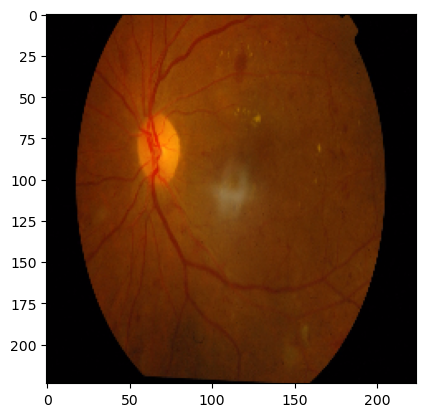

In [63]:
predict_new(r'C:\Users\santhosh\OneDrive\Desktop\diabetic retinopathy\testing\Moderate\0ac436400db4.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Predicted: NO_DR


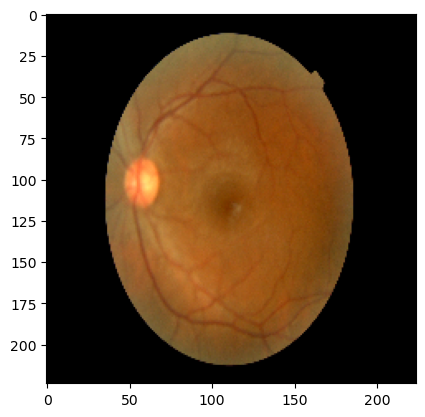

In [62]:
predict_new(r'C:\Users\santhosh\OneDrive\Desktop\diabetic retinopathy\testing\No_DR\0b8bdec9d869.png')

In [47]:
from tensorflow.keras.models import load_model
model.save(r'C:\Users\santhosh\OneDrive\Desktop\myvgg16_mode.h5')
loadedmodel=load_model(r'C:\Users\santhosh\OneDrive\Desktop\myvgg16_mode.h5')